## 10. K-means no Dólar Futuro
 

#### Etapas

- Passo 0 - Assitir às aulas anteriores de K-means
- Passo 1 - Carregar as bibliotecas
- Passo 2 - Carregar a base de dados
- Passo 3 - Tratamento dos dados
- Passo 4 - Construçao dos alvos e variaveis
- Passo 5 - Preparaçao da base para treinamento e teste
- Passo 6 - Avaliaçao dos numeros de clusters necessàrios
- Passo 7 - Avaliaçao dos Resultados
- Passo 8 - Analise bivariada
- Passo 9 - Retreinamento do K-means
- Passo 10 - Re-avaliaçao dos Resultados

 

________________________________________________________


### Passo 1 - Carregar as bibliotecas

In [1]:
# Carregando as bibliotecas

import time
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, precision_recall_curve, auc, make_scorer, recall_score
from sklearn.cluster import KMeans
import statsmodels.api as sm
import pandas as pd
import numpy as np


In [2]:
# Para remover os warnings
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

______________________________________________________

### Passo 2 - Carregar a base de dados

In [3]:
# Carregando a base de dados e fazendo os checks iniciais

# Muda o diretorio de trabalho
import os
os.chdir("C:\\Users\\engle\\OM Na Pratica\\Finanças Quantitativas\\Bases de Dados")

df1 = pd.read_csv("WDOFUT.csv", sep = ";")

df1.shape[0]

3854

In [4]:
df1.head()

,Data,Abertura,Maxima,Minima,Fechamento
0,17/05/2005,2487.0,2502.0,2487.0,2494.0
1,18/05/2005,2484.0,2484.0,2469.0,2470.0
2,19/05/2005,2455.0,2458.0,2450.0,2455.0
3,20/05/2005,2460.0,2463.0,2451.0,2451.0
4,23/05/2005,2443.0,2443.0,2432.0,2433.0


______________________________________________________

### Passo 3 - Tratamento dos dados

In [5]:
# Ajustando a data - precisamos transforma-la nos indices do data frame

df1["Data"] = pd.to_datetime(df1["Data"]).dt.normalize()

df1 = df1.set_index("Data")

In [6]:
df1.head()

,Abertura,Maxima,Minima,Fechamento
Data,,,,
2005-05-17,2487.0,2502.0,2487.0,2494.0
2005-05-18,2484.0,2484.0,2469.0,2470.0
2005-05-19,2455.0,2458.0,2450.0,2455.0
2005-05-20,2460.0,2463.0,2451.0,2451.0
2005-05-23,2443.0,2443.0,2432.0,2433.0


In [7]:
df1.describe()

,Abertura,Maxima,Minima,Fechamento
count,3854.000000,3854.000000,3854.000000,3854.000000
mean,2695.424453,2714.421069,2677.683342,2695.850519
std,996.551114,1006.839596,986.645656,997.148535
min,1534.500000,1542.000000,1530.000000,1541.500000
25%,1910.000000,1921.375000,1896.250000,1909.125000
50%,2275.500000,2292.750000,2260.000000,2274.750000
75%,3312.125000,3333.000000,3292.750000,3313.750000
max,5927.500000,5977.500000,5823.500000,5894.500000


______________________________________________________

### Passo 4 - Construçao dos alvos e variaveis

In [8]:
# Construcao dos alvos - Vamos trabalhar com um horizonte mais longo, de 5 periodos?

periodos = 1

# lag de X periodos
df1["Lag1"] = df1["Fechamento"].shift(-periodos)

# Alvo 1 - Retorno
df1["Retorno"] = df1["Fechamento"].pct_change(periodos)
df1["Alvo1"] = df1["Retorno"].shift(-periodos)

# Variaçao em Pontos do alvo
df1["Pontos"] = (df1["Fechamento"] - df1["Fechamento"].shift(1))
df1["Pontos"] = df1["Pontos"].shift(-periodos)

In [9]:
df1["Retorno"].describe()

count    3853.000000
mean        0.000246
std         0.011053
min        -0.079897
25%        -0.005851
50%         0.000000
75%         0.005831
max         0.078145
Name: Retorno, dtype: float64

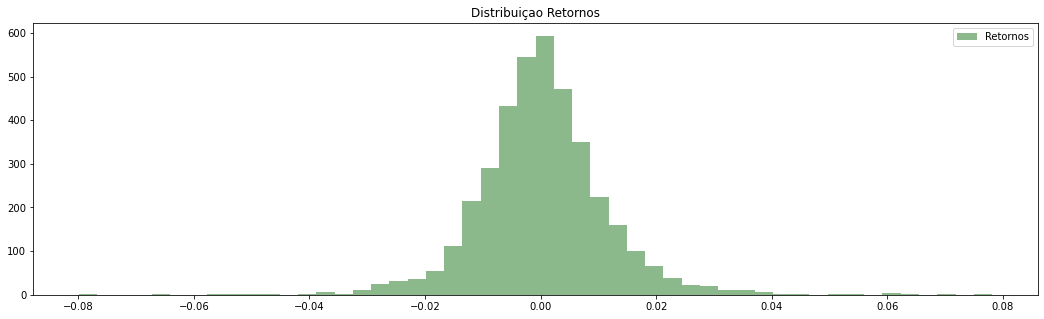

In [10]:
plt.figure(figsize = (18,5))
plt.hist(df1["Retorno"], bins = 50
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "darkgreen"
        , edgecolor = "none"
        , label = "Retornos");

plt.legend()
plt.title("Distribuiçao Retornos");

In [11]:
# Criacao do alvo
df1["Alvo_Bin"] = np.where(df1['Alvo1'] > df1["Retorno"].describe()[6]/2 , 1
                           , np.where(df1['Alvo1'] < df1["Retorno"].describe()[4]/2, -1, 0))

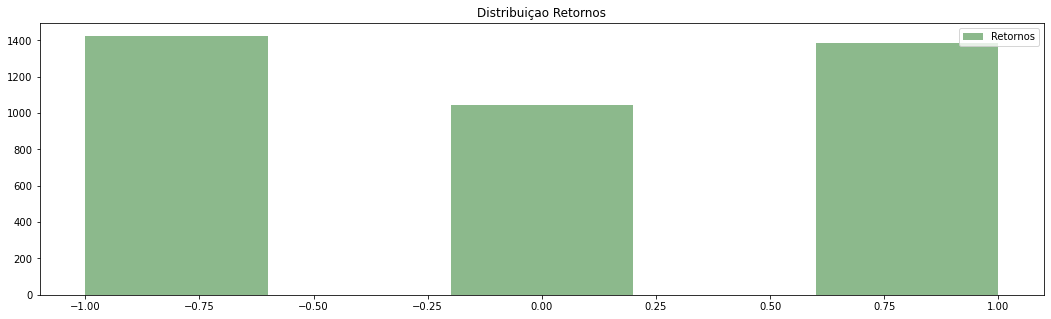

In [12]:
plt.figure(figsize = (18,5))
plt.hist(df1["Alvo_Bin"], bins = 5
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "darkgreen"
        , edgecolor = "none"
        , label = "Retornos");

plt.legend()
plt.title("Distribuiçao Retornos");

In [13]:
# Construçao das Variaveis

# Desvio Padrao de 5 dias
df1["std5"] = df1["Retorno"].rolling(5).std()

# Desvio Padrao de 10 dias
df1["std10"] = df1["Retorno"].rolling(10).std()

# Desvio Padrao de 15 dias
df1["std15"] = df1["Retorno"].rolling(15).std()

# Proporçao do corpo do candle em relacao ao range do dia
df1["prop"] = (df1["Fechamento"]-df1["Abertura"])/(df1["Maxima"]-df1["Minima"])

# Direçao do dia atual
df1["dir_D"] = np.where(df1['Fechamento'] > df1['Abertura'] , 1, 0)

# Direçao D-1
df1["dir_D-1"] = df1["dir_D"].shift(1)

# Direçao D-2
df1["dir_D-2"] = df1["dir_D"].shift(2)

# Direçao D-3
df1["dir_D-3"] = df1["dir_D"].shift(3)

# Media Movel de 15 dias std5
df1["mm_std5"] = df1["std5"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std10"] = df1["std10"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std15"] = df1["std15"].rolling(15).mean()

# RSL std5
df1["RSL_std5"] = (df1["std5"]/df1["std5"].rolling(15).mean())-1

# RSL std10
df1["RSL_std10"] = (df1["std10"]/df1["std10"].rolling(15).mean())-1

# RSL std15
df1["RSL_std15"] = (df1["std15"]/df1["std15"].rolling(15).mean())-1

# Aplicando a fisica

p = 5 

# Velocidade de p dias
df1["v"] = (df1["Retorno"] - df1["Retorno"].shift(p))/p

# Aceleraçao de p dias
df1["a"] = (df1["v"] - df1["v"].shift(p))/p

# Força
# Calculando a massa
df1["m"] = df1["Retorno"].rolling(p).sum()
df1["f"] = df1["m"]*df1["a"]

# Energia cinética
df1["T"] = 0.5*df1["m"]*df1["v"]*df1["v"]


# Trabalho 
# cateto_oposto
cat_op = df1["Retorno"].rolling(p).sum()-df1["Retorno"].rolling(1).sum()
cat_ad = p
df1["cat"] = cat_op/cat_ad
df1 = df1.dropna(axis = 0)
df1["w"] = df1["f"]*np.cos(np.arctan(df1["cat"]))

# Energia potencial
df1["k"] = cat_op*df1["m"]

# Torque
df1["tau"] = df1["f"]*np.sin(np.arctan(df1["cat"]))

# Momentum
df1["M"] = df1["m"]*df1["v"]

# Gravidade
df1["g"] = df1["m"]*df1["Retorno"].rolling(p).sum()/(df1["m"]/df1["Retorno"].rolling(p).sum())*(df1["m"]/df1["Retorno"].rolling(p).sum())

df1.head(10)

,Abertura,Maxima,Minima,Fechamento,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,std5,...,a,m,f,T,cat,w,k,tau,M,g
Data,,,,,,,,,,,,,,,,,,,,,
2005-06-28,2369.0,2375.0,2369.0,2374.0,2360.0,-0.002940,-0.005897,-14.0,-1,0.007640,...,0.000274,-0.004085,-1.119103e-06,-3.144358e-09,-0.000229,-1.119103e-06,0.000005,2.562563e-10,-0.000005,NaN
2005-06-29,2365.0,2365.0,2350.0,2360.0,2350.5,-0.005897,-0.004025,-9.5,-1,0.007206,...,-0.000768,-0.014596,1.121397e-05,-3.225396e-08,-0.001740,1.121395e-05,0.000127,-1.950994e-08,0.000031,NaN
2005-06-30,2346.0,2356.0,2346.0,2350.5,2371.0,-0.004025,0.008722,20.5,1,0.003145,...,-0.001223,-0.027390,3.350148e-05,-8.966265e-08,-0.004673,3.350111e-05,0.000640,-1.565469e-07,0.000070,NaN
2005-01-07,2357.0,2382.0,2357.0,2371.0,2392.0,0.008722,0.008857,21.0,1,0.005860,...,0.000912,-0.007907,-7.211111e-06,-6.002671e-08,-0.003326,-7.211071e-06,0.000131,2.398154e-08,-0.000031,NaN
2005-04-07,2400.0,2403.0,2392.0,2392.0,2404.0,0.008857,0.005017,12.0,1,0.007240,...,0.000756,0.004716,3.563098e-06,1.502823e-08,-0.000828,3.563097e-06,-0.000020,-2.950982e-09,0.000012,0.000022
2005-05-07,2400.0,2404.0,2384.0,2404.0,2415.0,0.005017,0.004576,11.0,1,0.007045,...,0.000070,0.012673,8.885036e-07,1.604573e-08,0.001531,8.885026e-07,0.000097,1.360462e-09,0.000020,0.000161
2005-06-07,2406.0,2422.0,2406.0,2415.0,2396.0,0.004576,-0.007867,-19.0,-1,0.005236,...,0.000839,0.023146,1.942769e-05,5.077316e-08,0.003714,1.942756e-05,0.000430,7.215345e-08,0.000048,0.000536
2005-07-07,2426.0,2427.0,2396.0,2396.0,2388.0,-0.007867,-0.003339,-8.0,-1,0.006855,...,0.000358,0.019304,6.911906e-06,5.698978e-09,0.005434,6.911804e-06,0.000524,3.756012e-08,-0.000015,0.000373
2005-08-07,2406.0,2406.0,2379.0,2388.0,2359.0,-0.003339,-0.012144,-29.0,-1,0.006839,...,-0.001262,0.007243,-9.138882e-06,2.107069e-08,0.002116,-9.138861e-06,0.000077,-1.934141e-08,-0.000017,0.000052


In [14]:
# Filtrando os valores missing

df1_filtrado = df1.dropna(axis = 0) 

df1_filtrado= df1_filtrado.drop(["std5","std10","std15","mm_std5","mm_std10","mm_std15"], axis = 1)

In [15]:
corte = 10

df1_filtrado["RSL_std5"] = pd.qcut(df1_filtrado["RSL_std5"], corte, labels = False)
df1_filtrado["RSL_std10"] = pd.qcut(df1_filtrado["RSL_std10"], corte, labels = False)
df1_filtrado["RSL_std15"] = pd.qcut(df1_filtrado["RSL_std15"], corte, labels = False)
df1_filtrado["v"] = pd.qcut(df1_filtrado["v"], corte, labels = False)
df1_filtrado["a"] = pd.qcut(df1_filtrado["a"], corte, labels = False)
df1_filtrado["m"] = pd.qcut(df1_filtrado["m"], corte, labels = False)
df1_filtrado["f"] = pd.qcut(df1_filtrado["f"], corte, labels = False)
df1_filtrado["T"] = pd.qcut(df1_filtrado["T"], corte, labels = False)
df1_filtrado["w"] = pd.qcut(df1_filtrado["w"], corte, labels = False)
df1_filtrado["k"] = pd.qcut(df1_filtrado["k"], corte, labels = False)
df1_filtrado["tau"] = pd.qcut(df1_filtrado["tau"], corte, labels = False)
df1_filtrado["M"] = pd.qcut(df1_filtrado["M"], corte, labels = False)
df1_filtrado["g"] = pd.qcut(df1_filtrado["g"], corte, labels = False)

In [16]:
pd.crosstab(pd.qcut(df1["RSL_std5"], corte, labels = False), df1["Alvo_Bin"])/df1.shape[0]*100

Alvo_Bin,-1,0,1
RSL_std5,,,
0,3.294979,2.955021,3.765690
1,3.817992,2.771967,3.399582
2,4.184100,2.588912,3.216527
3,3.713389,2.641213,3.661088
4,3.817992,2.693515,3.478033
5,3.687238,2.536611,3.765690
6,3.347280,2.981172,3.687238
7,3.713389,2.981172,3.294979
8,3.530335,2.641213,3.817992


In [17]:
pd.crosstab(pd.qcut(df1["RSL_std5"], 5, labels = False), df1["Alvo_Bin"])/df1.shape[0]*100

Alvo_Bin,-1,0,1
RSL_std5,,,
0,7.112971,5.726987,7.165272
1,7.897490,5.230126,6.877615
2,7.505230,5.230126,7.243724
3,7.060669,5.962343,6.982218
4,7.217573,4.994770,7.792887


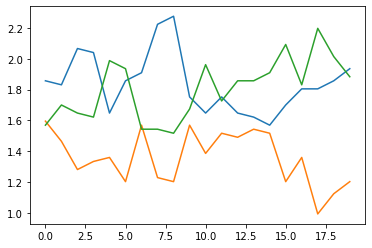

In [18]:
plt.plot(pd.crosstab(pd.qcut(df1["RSL_std10"], 20, labels = False), df1["Alvo_Bin"])/df1.shape[0]*100);

In [19]:
df1_filtrado.tail()

,Abertura,Maxima,Minima,Fechamento,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,prop,...,a,m,f,T,cat,w,k,tau,M,g
Data,,,,,,,,,,,,,,,,,,,,,
2020-08-12,5121.5,5139.5,5063.0,5120.0,5172.5,0.004020,0.010254,52.5,1,-0.019608,...,9,1,0,0,-0.004200,0,7,9,0,6
2020-09-12,5100.5,5198.0,5087.0,5172.5,5027.5,0.010254,-0.028033,-145.0,-1,0.648649,...,4,3,5,2,-0.003837,5,5,2,1,3
2020-10-12,5112.0,5133.0,5016.0,5027.5,5070.5,-0.028033,0.008553,43.0,1,-0.722222,...,5,1,3,0,0.000762,3,0,4,8,7
2020-11-12,5055.0,5089.0,5029.5,5070.5,5117.5,0.008553,0.009269,47.0,1,0.260504,...,6,1,1,2,-0.005058,1,7,8,1,6
2020-12-14,5039.0,5131.0,5010.5,5117.5,5089.5,0.009269,-0.005471,-28.0,-1,0.651452,...,8,5,6,8,-0.001041,6,0,3,6,1


In [20]:
df1_filtrado.columns

Index(['Abertura', 'Maxima', 'Minima', 'Fechamento', 'Lag1', 'Retorno',
       'Alvo1', 'Pontos', 'Alvo_Bin', 'prop', 'dir_D', 'dir_D-1', 'dir_D-2',
       'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15', 'v', 'a', 'm', 'f',
       'T', 'cat', 'w', 'k', 'tau', 'M', 'g'],
      dtype='object')

In [21]:
df1_filtrado = df1_filtrado.drop(["m","cat","M"], axis=1)

______________________________________________________

### Passo 5 - Preparaçao da base para treinamento e teste

In [22]:
# Separando os dados entre treinamento e teste

# Vamos treinar o modelo de 2005 à 2012
start_train = "2005-08-07"
end_train = "2012-12-31"

# Vamos testar o modelo de 2013 à 2020
start_test = "2013-01-01"
end_test = "2020-12-08"

df1_train1 = df1_filtrado.loc[start_train : end_train]

df1_test1 = df1_filtrado.loc[start_test : end_test]

In [23]:
df1_test1.head()

,Abertura,Maxima,Minima,Fechamento,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,prop,...,RSL_std10,RSL_std15,v,a,f,T,w,k,tau,g
Data,,,,,,,,,,,,,,,,,,,,,
2013-02-01,2041.0,2056.5,2041.0,2055.5,2057.0,-0.001700,0.000730,1.5,0,0.935484,...,3,0,4,6,2,4,2,3,6,3
2013-03-01,2057.0,2059.5,2043.5,2057.0,2043.5,0.000730,-0.006563,-13.5,-1,0.000000,...,4,0,3,3,6,3,6,5,2,4
2013-04-01,2057.5,2059.0,2041.0,2043.5,2039.0,-0.006563,-0.002202,-4.5,0,-0.777778,...,3,1,7,8,2,3,2,0,3,1
2013-07-01,2044.0,2045.5,2033.0,2039.0,2050.0,-0.002202,0.005395,11.0,1,-0.400000,...,3,1,5,4,4,4,4,1,4,1
2013-08-01,2036.5,2050.0,2029.5,2050.0,2050.0,0.005395,0.000000,0.0,0,0.658537,...,4,2,4,2,6,4,6,3,2,2


In [24]:
df1_filtrado.columns

Index(['Abertura', 'Maxima', 'Minima', 'Fechamento', 'Lag1', 'Retorno',
       'Alvo1', 'Pontos', 'Alvo_Bin', 'prop', 'dir_D', 'dir_D-1', 'dir_D-2',
       'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15', 'v', 'a', 'f', 'T',
       'w', 'k', 'tau', 'g'],
      dtype='object')

In [25]:
# Separando os dados com as variaveis em x e o alvo em y
 
x_train1 = df1_train1.iloc[:, 9:24]
y_train1 = df1_train1['Alvo_Bin'].values.reshape(-1, 1)

x_test1 = df1_test1.iloc[:, 9:24]
y_test1 = df1_test1['Alvo_Bin'].values.reshape(-1, 1)

______________________________________________________

### Passo 6 - Avaliaçao dos numeros de clusters necessàrios


In [26]:
min_clusters = 2
max_clusters = 20
inertias = np.zeros(shape = (max_clusters - min_clusters + 1,))

In [27]:
for i in range(min_clusters, max_clusters + 1):
    km = KMeans(n_clusters = i, random_state = 42)
    km.fit(x_train1)
    inertias[i - min_clusters] = km.inertia_

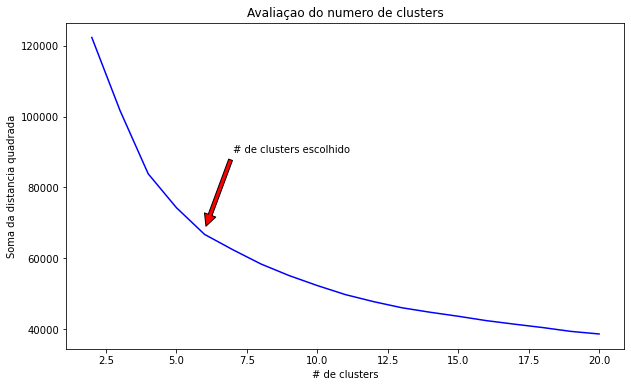

In [31]:
plt.figure(figsize = (10, 6))
plt.plot(range(min_clusters, max_clusters + 1), inertias, color = "b")
plt.title("Avaliaçao do numero de clusters")
plt.xlabel("# de clusters")
plt.ylabel("Soma da distancia quadrada")
plt.annotate("# de clusters escolhido", xy = (6, 68000), xytext = (7, 90000),
            arrowprops = dict(facecolor = "red", shrink = 0.05),
            );

In [32]:
kmodel = KMeans(n_clusters = 6, random_state = 42)
clusters = kmodel.fit(x_train1)

In [33]:
# Acessando os clusters

clusters.labels_

array([5, 0, 0, ..., 0, 4, 4])

In [34]:
# Aplicando os clusters na base de treinamento e na base de teste
# Atribuido-os à base de treinamento e teste

train_clusters = pd.DataFrame(clusters.labels_,columns = ["Cluster"])
train_clusters["Label"] = y_train1
train_clusters["Alvo1"] = df1_train1['Alvo1'].values.reshape(-1, 1)


fitted_clusters = kmodel.predict(x_test1)
test_clusters = pd.DataFrame(fitted_clusters,columns = ["Cluster"])
test_clusters["Label"] = y_test1
test_clusters["Alvo1"] = df1_test1['Alvo1'].values.reshape(-1, 1)

In [35]:
train_clusters.head()

,Cluster,Label,Alvo1
0,5,-1,-0.012144
1,0,0,-0.001696
2,0,1,0.006369
3,4,-1,-0.019108
4,0,-1,-0.003030


In [36]:
test_clusters.head()

,Cluster,Label,Alvo1
0,2,0,0.000730
1,0,-1,-0.006563
2,2,0,-0.002202
3,2,1,0.005395
4,2,0,0.000000


In [37]:
pd.crosstab(train_clusters["Cluster"], train_clusters["Label"])

Label,-1,0,1
Cluster,,,
0,102,97,104
1,107,60,95
2,181,190,128
3,102,108,107
4,93,63,85
5,86,26,77


In [38]:
train_clusters.groupby("Cluster")["Alvo1"].mean()

Cluster
0    0.000535
1   -0.000230
2   -0.000586
3    0.000693
4   -0.000246
5    0.000283
Name: Alvo1, dtype: float64

In [39]:
train_clusters.groupby("Cluster")["Alvo1"].sum()

Cluster
0    0.162087
1   -0.060139
2   -0.292625
3    0.219776
4   -0.059273
5    0.053431
Name: Alvo1, dtype: float64

______________________________________________________

### Passo 7 - Avaliaçao dos Resultados

In [40]:
# Calculando a performance - para toda a base

y_pred_all = kmodel.predict(df1_filtrado.iloc[:, 9:24])
df1_filtrado.loc[: , "Clusters"] = y_pred_all

In [41]:
df1_filtrado.loc[: , "Previsto"] = np.where(((df1_filtrado.loc[: , "Clusters"] == 0) | (df1_filtrado.loc[: , "Clusters"] == 3)), 1,
                                           np.where((df1_filtrado.loc[: , "Clusters"] == 2),-1
                                                   ,0))

In [42]:
df1_filtrado.loc[: , "Retorno_Modelo"] = df1_filtrado.loc[: , "Previsto"]*df1_filtrado["Alvo1"]

In [43]:
df1_filtrado.loc[: , "Retorno_Modelo_Acumulado"] = df1_filtrado["Retorno_Modelo"].cumsum()

In [44]:
df1_filtrado.loc[: , "Retorno_Modelo_Acumulado"].tail()

Data
2020-08-12    1.161336
2020-09-12    1.189368
2020-10-12    1.197921
2020-11-12    1.197921
2020-12-14    1.197921
Name: Retorno_Modelo_Acumulado, dtype: float64

In [45]:
# Faz uma copia de df1_filtrado
df_stats = df1_filtrado.copy()

In [46]:
# Para fazer um conditional plot

df1_filtrado.index.name = "Date"
df1_filtrado.reset_index(inplace = True)

df1_filtrado["Date"] = pd.to_datetime(df1_filtrado["Date"])

df1_filtrado["train_test"] = np.where(df1_filtrado["Date"] > end_train, 1, -1)

In [47]:
base_agregada = df1_filtrado.resample("M", on = "Date").sum()

base_agregada.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada["Retorno_Modelo"].cumsum()*100

""


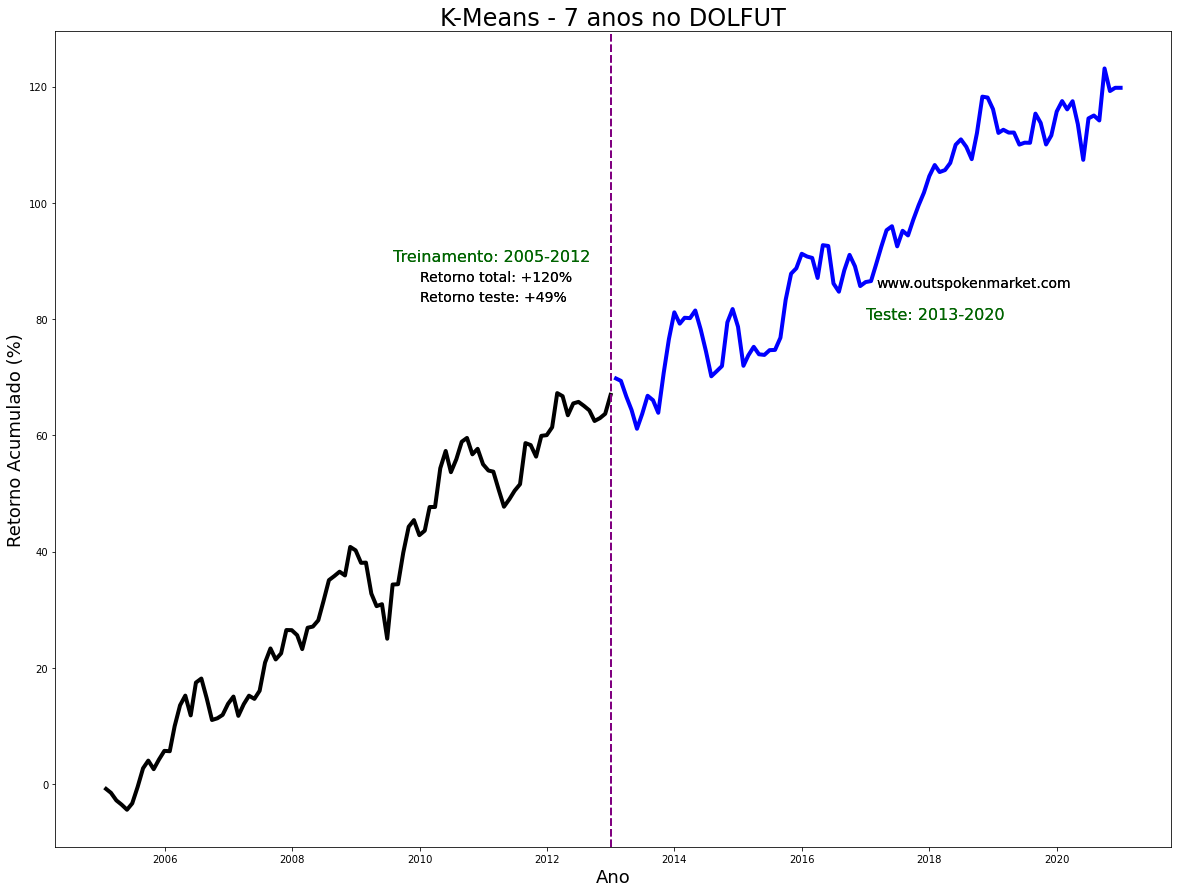

In [48]:
# Plota o grafico
fig, ax = plt.subplots(figsize = (20,15))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c=color, linewidth=lw)
    plt.xlabel("Ano"
           , fontsize = 18);
    plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 18);
    plt.title("K-Means - 7 anos no DOLFUT", fontsize = 24)
    plt.axvline( x = end_train, color='purple', linestyle = "--", lw = 2)
    setup = dict(size = 16, color = "darkgreen")
    setup2 = dict(size = 14, color = "black")
    plt.text("2009-08-01", 90, "Treinamento: 2005-2012", **setup)
    plt.text("2017-01-01", 80, "Teste: 2013-2020", **setup)
    plt.text("2010-01-01", 86.5, "Retorno total: +120%", **setup2)
    plt.text("2010-01-01", 83.0, "Retorno teste: +49%", **setup2)
    plt.text("2017-03-01", 85.5, "www.outspokenmarket.com", **setup2)

base_agregada.groupby((base_agregada["train_test"].shift() * base_agregada["train_test"] < 0).cumsum()).apply(grafico)


In [49]:
import collections

collections.Counter(y_pred_all)

Counter({2: 983, 1: 648, 5: 449, 0: 616, 3: 644, 4: 480})

In [50]:
np.count_nonzero((y_pred_all == 0) | (y_pred_all == 3) | (y_pred_all == 2))

2243

In [51]:
len(y_pred_all)

3820

In [52]:
long = np.count_nonzero((y_pred_all == 0) | (y_pred_all == 3))
short = np.count_nonzero(y_pred_all == 2)
trades = np.count_nonzero((y_pred_all == 0) | (y_pred_all == 3) | (y_pred_all == 2))
total = len(y_pred_all)

In [54]:
print("K-Means: DolFut - 2003 à 2020")
print("Outspoken Market")
print("--------------------------")
print("# Pregoes:       ", total)
print("# Trades:        ", trades)
print("--------------------------")
print("Tempo em trades: ", round(trades/total*100,2),"%")
print("Tempo em Long:   ", round(long/total*100,2),"%")
print("Tempo em Short:  ", round(short/total*100,2),"%")
print("--------------------------")
print("Trades em Long:  ", round(long/trades*100,2),"%")
print("Trades em Short: ", round(short/trades*100,2),"%")

K-Means: DolFut - 2003 à 2020
Outspoken Market
--------------------------
# Pregoes:        3820
# Trades:         2243
--------------------------
Tempo em trades:  58.72 %
Tempo em Long:    32.98 %
Tempo em Short:   25.73 %
--------------------------
Trades em Long:   56.17 %
Trades em Short:  43.83 %


In [55]:
df_stats.groupby("Clusters")["Retorno_Modelo"].sum()*100

Clusters
0    38.227070
1     0.000000
2    18.438902
3    63.126171
4     0.000000
5     0.000000
Name: Retorno_Modelo, dtype: float64

In [56]:
test_clusters.groupby("Cluster")["Alvo1"].sum()

Cluster
0    0.253278
1   -0.064995
2    0.116478
3    0.391563
4    0.271128
5    0.058095
Name: Alvo1, dtype: float64

______________________________________________________

### Passo 8 - Analise bivariada

In [57]:
df_stats_train = df_stats.loc[start_train : end_train]

df_stats_test = df_stats.loc[start_test : end_test]

In [58]:
df_stats.columns

Index(['Abertura', 'Maxima', 'Minima', 'Fechamento', 'Lag1', 'Retorno',
       'Alvo1', 'Pontos', 'Alvo_Bin', 'prop', 'dir_D', 'dir_D-1', 'dir_D-2',
       'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15', 'v', 'a', 'f', 'T',
       'w', 'k', 'tau', 'g', 'Clusters', 'Previsto', 'Retorno_Modelo',
       'Retorno_Modelo_Acumulado'],
      dtype='object')

In [59]:
df_stats_train[df_stats_train.Clusters.isin([0,3,2])].groupby("Clusters")['prop', 'dir_D', 'dir_D-1', 'dir_D-2',
       'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15', 'v', 'a', 'f', 'T',
       'w', 'k', 'tau', 'g'].mean()

,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15,v,a,f,T,w,k,tau,g
Clusters,,,,,,,,,,,,,,,,
0,-0.294906,0.300330,0.346535,0.372937,0.346535,3.775578,4.333333,4.376238,1.452145,1.349835,7.666667,1.039604,7.666667,5.874587,1.323432,6.270627
2,-0.007753,0.468938,0.515030,0.486974,0.472946,2.719439,1.817635,2.084168,4.663327,4.611222,4.110220,4.513026,4.110220,2.567134,4.364729,2.282565
3,-0.081234,0.425868,0.438486,0.438486,0.492114,6.946372,6.965300,6.353312,4.100946,4.186120,3.892744,4.015773,3.892744,2.239748,4.750789,2.223975


In [60]:
df_stats_test[df_stats_test.Clusters.isin([0,3,2])].groupby("Clusters")['prop', 'dir_D', 'dir_D-1', 'dir_D-2',
       'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15', 'v', 'a', 'f', 'T',
       'w', 'k', 'tau', 'g'].mean()

,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15,v,a,f,T,w,k,tau,g
Clusters,,,,,,,,,,,,,,,,
0,-0.317041,0.264706,0.352941,0.359477,0.326797,4.022876,4.392157,4.385621,1.444444,1.310458,7.732026,1.003268,7.732026,5.911765,1.454248,6.30719
2,0.019188,0.518750,0.522917,0.497917,0.550000,2.614583,1.972917,2.304167,4.658333,4.535417,4.066667,4.970833,4.066667,2.654167,4.433333,2.50625
3,-0.072823,0.450000,0.478125,0.503125,0.512500,6.825000,6.843750,6.281250,3.928125,3.950000,4.134375,3.978125,4.134375,2.259375,4.775000,2.61875


In [61]:
# Separando os dados com as variaveis em x e o alvo em y
 
x_train1 = df_stats_train.iloc[:, 9:16]
y_train1 = df_stats_train['Alvo_Bin'].values.reshape(-1, 1)

x_test1 = df_stats_test.iloc[:, 9:16]
y_test1 = df_stats_test['Alvo_Bin'].values.reshape(-1, 1)

______________________________________________________

### Passo 9 - Retreinamento do K-means


In [62]:
min_clusters = 2
max_clusters = 20
inertias = np.zeros(shape = (max_clusters - min_clusters + 1,))

In [63]:
for i in range(min_clusters, max_clusters + 1):
    km = KMeans(n_clusters = i, random_state = 42)
    km.fit(x_train1)
    inertias[i - min_clusters] = km.inertia_

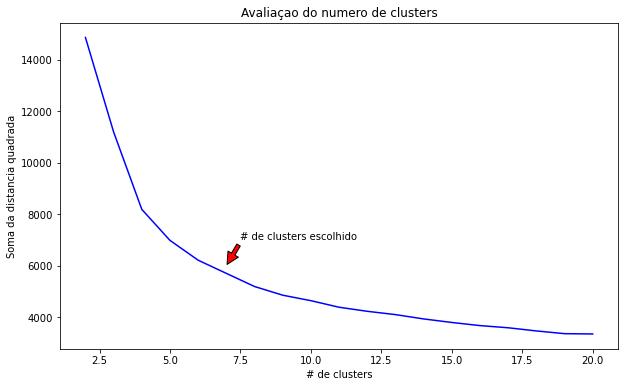

In [64]:
plt.figure(figsize = (10, 6))
plt.plot(range(min_clusters, max_clusters + 1), inertias, color = "b")
plt.title("Avaliaçao do numero de clusters")
plt.xlabel("# de clusters")
plt.ylabel("Soma da distancia quadrada")
plt.annotate("# de clusters escolhido", xy = (7, 6000), xytext = (7.5, 7000),
            arrowprops = dict(facecolor = "red", shrink = 0.05),
            );

In [65]:
kmodel = KMeans(n_clusters = 6, random_state = 42)
clusters = kmodel.fit(x_train1)

In [66]:
# Acessando os clusters

clusters.labels_

array([2, 1, 5, ..., 2, 2, 1])

In [67]:
# Aplicando os clusters na base de treinamento e na base de teste
# Atribuido-os à base de treinamento e teste

train_clusters = pd.DataFrame(clusters.labels_,columns = ["Cluster"])
train_clusters["Label"] = y_train1
train_clusters["Alvo1"] = df1_train1['Alvo1'].values.reshape(-1, 1)


fitted_clusters = kmodel.predict(x_test1)
test_clusters = pd.DataFrame(fitted_clusters,columns = ["Cluster"])
test_clusters["Label"] = y_test1
test_clusters["Alvo1"] = df1_test1['Alvo1'].values.reshape(-1, 1)

In [68]:
pd.crosstab(train_clusters["Cluster"], train_clusters["Label"])

Label,-1,0,1
Cluster,,,
0,163,129,127
1,78,58,61
2,132,121,107
3,132,76,133
4,76,74,86
5,90,86,82


In [69]:
train_clusters.groupby("Cluster")["Alvo1"].sum()

Cluster
0   -0.072615
1   -0.103731
2   -0.218418
3    0.323700
4    0.144395
5   -0.050075
Name: Alvo1, dtype: float64

______________________________________________________

### Passo 10 - Re-avaliaçao dos Resultados

In [70]:
# Calculando a performance - para toda a base

y_pred_all = kmodel.predict(df_stats.iloc[:, 9:16])
df_stats.loc[: , "Clusters"] = y_pred_all

In [71]:
df_stats.loc[: , "Previsto"] = np.where(((df_stats.loc[: , "Clusters"] == 3) ), 1,
                                           np.where((df_stats.loc[: , "Clusters"] == 2),-1
                                                   ,0))

In [72]:
df_stats.loc[: , "Retorno_Modelo"] = df_stats.loc[: , "Previsto"]*df_stats["Alvo1"]

In [73]:
df_stats.loc[: , "Retorno_Modelo_Acumulado"] = df_stats["Retorno_Modelo"].cumsum()

In [74]:
df_stats.loc[: , "Retorno_Modelo_Acumulado"].tail()

Data
2020-08-12    1.044040
2020-09-12    1.072072
2020-10-12    1.080625
2020-11-12    1.089895
2020-12-14    1.084423
Name: Retorno_Modelo_Acumulado, dtype: float64

In [75]:
# Para fazer um conditional plot

df_stats.index.name = "Date"
df_stats.reset_index(inplace = True)

df_stats["Date"] = pd.to_datetime(df_stats["Date"])

df_stats["train_test"] = np.where(df_stats["Date"] > end_train, 1, -1)

In [76]:
base_agregada = df_stats.resample("M", on = "Date").sum()

base_agregada.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada["Retorno_Modelo"].cumsum()*100

""


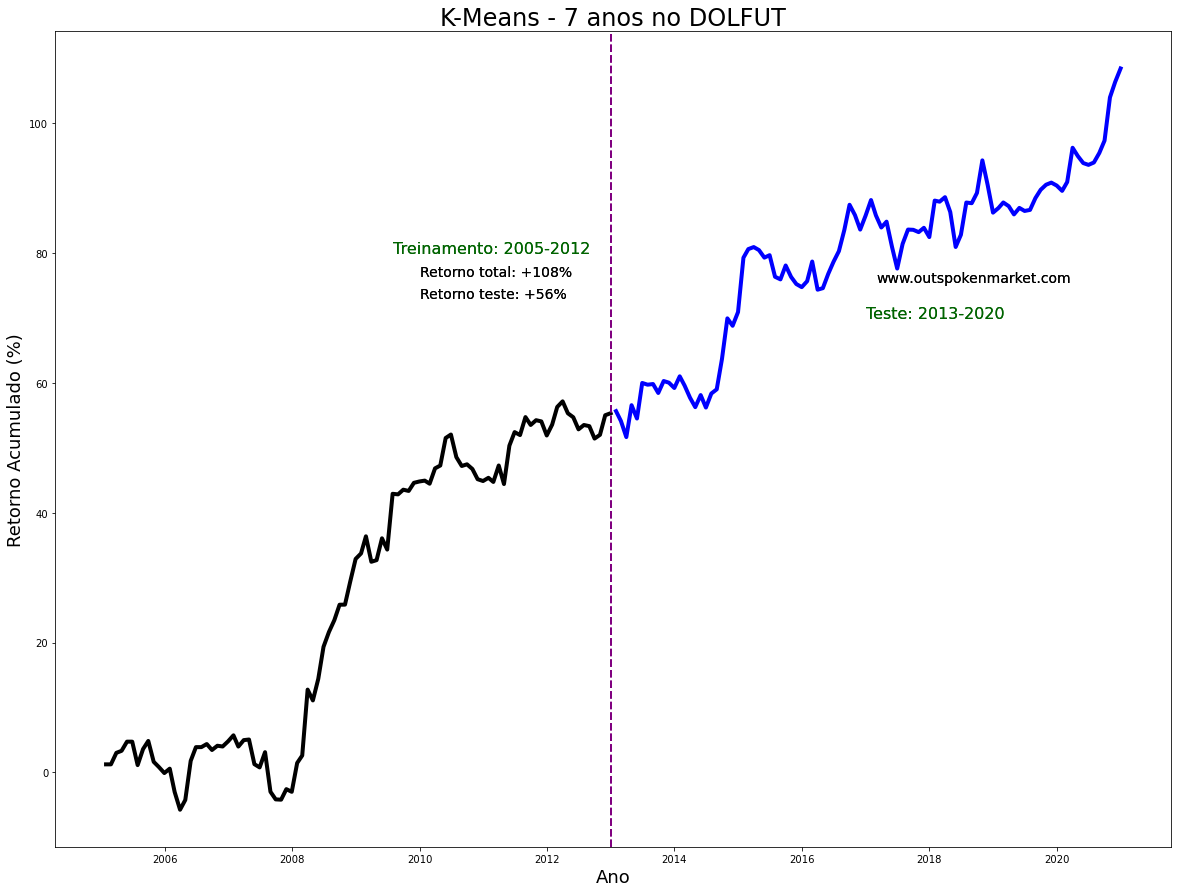

In [77]:
# Plota o grafico
fig, ax = plt.subplots(figsize = (20,15))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c=color, linewidth=lw)
    plt.xlabel("Ano"
           , fontsize = 18);
    plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 18);
    plt.title("K-Means - 7 anos no DOLFUT", fontsize = 24)
    plt.axvline( x = end_train, color='purple', linestyle = "--", lw = 2)
    setup = dict(size = 16, color = "darkgreen")
    setup2 = dict(size = 14, color = "black")
    plt.text("2009-08-01", 80, "Treinamento: 2005-2012", **setup)
    plt.text("2017-01-01", 70, "Teste: 2013-2020", **setup)
    plt.text("2010-01-01", 76.5, "Retorno total: +108%", **setup2)
    plt.text("2010-01-01", 73.0, "Retorno teste: +56%", **setup2)
    plt.text("2017-03-01", 75.5, "www.outspokenmarket.com", **setup2)

base_agregada.groupby((base_agregada["train_test"].shift() * base_agregada["train_test"] < 0).cumsum()).apply(grafico)


In [ ]:
test_clusters.groupby("Cluster")["Alvo1"].sum()